## Advection

In [8]:
import h5py

path = "/home/cmu/anthony/data_gen/pde_data/advection_1024.h5"
f = h5py.File(path, 'r')

In [13]:
data=f['Advection_tensor(1.0992)']

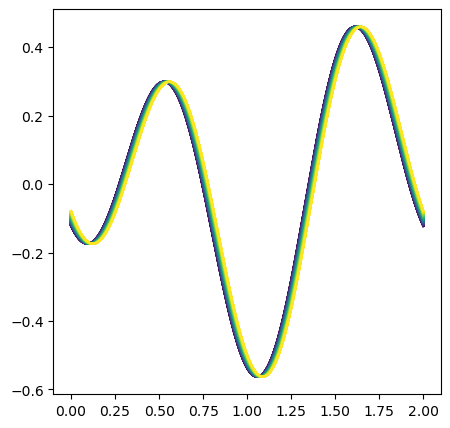

In [14]:
from mp_code.utils import plot_traj
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
rollout = data['pde_250-200'][0]
plot_traj(rollout, ax)

In [10]:
import h5py

path = "/home/cmu/anthony/data_gen/pde_data/2d_adv_1024ns_128nx_128ny"
f = h5py.File(path, 'r')

In [13]:
data = f["0.1241_0.5103"]
u = data["u"]

saved


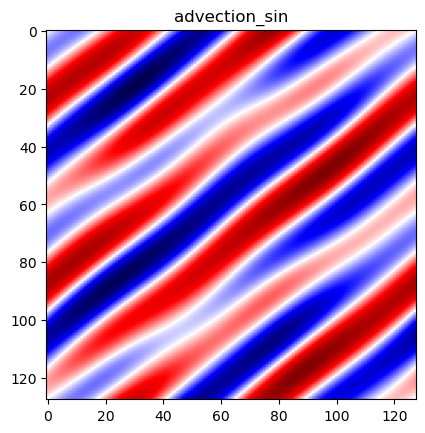

In [14]:
from utils import vis_2d

vis_2d(u, "advection_sin")

## 2D Advection

In [5]:
import numpy
import torch
import scipy.io
from utils import RandomSin

seed = 10
nx = 128
ny = 128
cx = 2
cy = 5

TOTAL_TIME = 1
SAVE_STEPS = 100

dt = TOTAL_TIME/SAVE_STEPS
nt = int(numpy.ceil(TOTAL_TIME/dt))

x = numpy.linspace(-1, 1, nx)
y = numpy.linspace(-1, 1, ny)

# Generate initial Gaussian pulse
adv_fn = RandomSin((nx, ny))

grid = numpy.meshgrid(x, y)
u = torch.Tensor(adv_fn.sample(grid=grid, seed=seed))
u0 = u.clone()

all_us = torch.empty((nt, nx, ny))
all_vs = torch.empty((nt, nx, ny))
times = torch.empty(nt)

for n in range(1, nt+1): ##loop across number of time steps
    x_adv = -dt*n*cx
    y_adv = -dt*n*cy

    # Make new grid and subtract c*t
    new_x = x - x_adv
    new_y = y - y_adv
    new_grid = numpy.meshgrid(new_x, new_y)

    # Sample function at new grid
    new_u = torch.Tensor(adv_fn.sample(grid=new_grid, seed=seed))
    
    all_us[n-1] = new_u.clone()
    times[n-1] = TOTAL_TIME*(n)/nt

## Initial Conditions

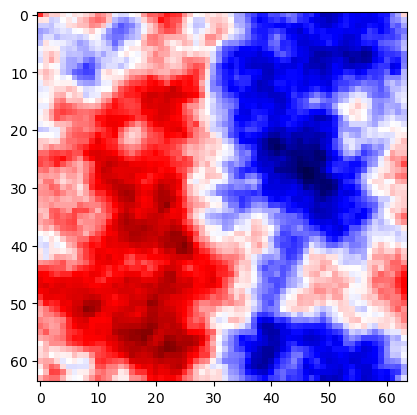

In [31]:
from FyeldGenerator import generate_field
import matplotlib.pyplot as plt
import numpy as np

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)

    return Pk


# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0.1, scale=1, size=shape)
    b = np.random.normal(loc=0.1, scale=1, size=shape)
    return a + 1j * b


shape = (64, 64)

field = generate_field(distrib, Pkgen(3.5), shape)

plt.imshow(field, cmap="seismic")

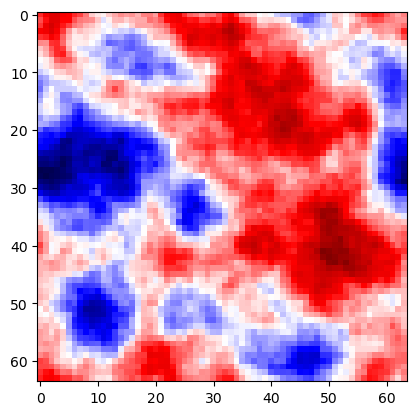

In [42]:
from FyeldGenerator import generate_field
import matplotlib.pyplot as plt
import numpy as np

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)
    return Pk

# Draw samples from a normal distribution

def distrib(shape):
    np.random.seed(1)
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b


shape = (64, 64)

field = generate_field(distrib, Pkgen(3.5), shape)

plt.imshow(field, cmap="seismic")

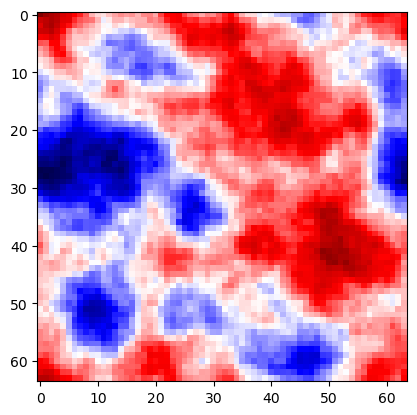

In [46]:
from FyeldGenerator import generate_field
import matplotlib.pyplot as plt
import numpy as np

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)
    return Pk

# Draw samples from a normal distribution

def distrib(shape):
    np.random.seed(1)
    a = np.random.normal(loc=0, scale=1, size=shape) + 0.1
    b = np.random.normal(loc=0, scale=1, size=shape) + 0.1
    return a + 1j * b


shape = (64, 64)

field = generate_field(distrib, Pkgen(3.5), shape)

plt.imshow(field, cmap="seismic")